# disaster_response_messages

The file contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

Then the text were manually classified whether the tweet referred to a disaster event or not (a joke with the word or a movie review or something non-disastrous).

The data structure were inherited from Disasters on social media (https://www.figure-eight.com/data-for-everyone/).

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt
import nltk
pd.options.display.min_rows=100
pd.options.display.width=75

ModuleNotFoundError: No module named 'nltk'

In [ ]:
df=pd.read_csv('data/tweets.csv')

df.set_index('id',inplace=True)
df.keyword.value_counts()

In [ ]:
# Cleaning Data
# text preprocessing
df['text'].iloc[3]

In [ ]:

df['text']=df['text'].str.strip()
df['text']=df['text'].str.lower()



In [ ]:
# Expand the Contractions
# To expand the contraction in English such as we'll -> we will or we shouldn't've -> we should not have.
## !pip install contractions

# I was not able to install contractions

### Remove Noises:
Text data could include various unnecessary characters or punctuation such as URLs, HTML tags, non-ASCII characters, or other special characters (symbols, emojis, and other graphic characters).

In [ ]:
# Removing url
#df['text'].str.replace(r'\bhttp://.*\b')
display(df['text'].iloc[3])

In [2]:
def remove_url(text):
    return re.sub(r'https?://.*\b','',text)
df['text']=df['text'].apply(lambda x: remove_url(x))

NameError: name 'df' is not defined

In [3]:
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, "", text)
df['text']=df['text'].apply(lambda x : remove_html(x))


NameError: name 'df' is not defined

In [14]:
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 
df['text']=df['text'].apply(lambda x: remove_non_ascii(x))

In [15]:
df['text'].iloc[3]

'arsonist sets cars ablaze at dealership'

In [16]:
# Some tweets has emojies. They should be eliminated from the text.
# e.g.
df['text'].loc[17]

'rengoku sets my heart ablaze p.s. i missed this style of coloring i do so here it is c: #'

In [17]:
# The following function revomes the emojis from text. 'apply' function should be used for each text.
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [18]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [19]:
df['text'].loc[17]

'rengoku sets my heart ablaze p.s. i missed this style of coloring i do so here it is c: #'

In [20]:
df['text'].loc[11366]

'i feel directly attacked  i consider moonbin  jinjin as my bias and im currently wrecked by rocky i hate this'

In [21]:
import string
string.punctuation
def remove_punc(text):
    return text.translate(text.maketrans('','',string.punctuation))
df['text']=df['text'].apply(lambda x: remove_punc(x))
df['text']

id
0        communal violence in bhainsa telangana stones ...
1        telangana section 144 has been imposed in bhai...
2                  arsonist sets cars ablaze at dealership
3                  arsonist sets cars ablaze at dealership
4        lord jesus your love brings freedom and pardon...
5        if this child was chinese this tweet would hav...
6        several houses have been set ablaze in ngemsib...
7        asansol a bjp office in salanpur village was s...
8        national security minister kan dapaahs side ch...
9        this creature whos soul is no longer clarent b...
10       images showing the havoc caused by the cameroo...
11       social media went bananas after chuba hubbard ...
12       hausa youths set area office of apapaiganmu lo...
13       under mamatabanerjee political violence  vanda...
14                    amen set the whole system ablaze man
15       images showing the havoc caused by the cameroo...
16       no cows today but our local factory is sadly

## Replace the Typos, slang, acronyms or informal abbreviations:
- Replace the Unicode character with equivalent ASCII character (instead of removing)
- Replace the entity references with their actual symbols  instead of removing as HTML tags
- Replace the Typos, slang, acronyms or informal abbreviations - depend on different situations or main topics of the NLP such as finance or medical topics.
- List out all the hashtags/ usernames then replace with equivalent words
- Replace the emoticon/ emoji with equivalant word meaning such as ":)" with "smile" 
- Spelling correction

In [22]:
def other_clean(text):
        
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text

In [23]:

df['text']=df['text'].apply(lambda x : other_clean(x))

In [24]:
# removing duplicate rows
df.drop_duplicates(subset=['text'], keep='first',inplace=True)
df.head()

,keyword,location,text,target
id,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1
1,ablaze,NaN,telangana section 144 has been imposed in bhai...,1
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0
5,ablaze,OC,if this child was chinese this tweet would hav...,0


### Spelling Correction
you can use textblob.TextBlob to correct the typo. But it should be used very carefully as it might change the meaning of the text.

From textblob import TextBlob

e.g.:

print("Test: ", TextBlob("sleapy and tehre is no plaxe I'm gioong to.").correct())

## Text Preprocessing:

In [25]:
# Tekenization:
from nltk import word_tokenize
df['tokenized']=df['text'].apply(word_tokenize)
df.head()

,keyword,location,text,target,tokenized
id,,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1,"[communal, violence, in, bhainsa, telangana, s..."
1,ablaze,NaN,telangana section 144 has been imposed in bhai...,1,"[telangana, section, 144, has, been, imposed, ..."
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1,"[arsonist, sets, cars, ablaze, at, dealership]"
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0,"[lord, jesus, your, love, brings, freedom, and..."
5,ablaze,OC,if this child was chinese this tweet would hav...,0,"[if, this, child, was, chinese, this, tweet, w..."


In [26]:
# Removing stop words:
#from nltk.corpus import stopwords
#stop=stopwords.words('English')
# df['stop_words_removed']=df['tokenized'].apply(lambda x : [word for word in x if not in stops])

# stop = set(stopwords.words('english'))
#df['stopwords_removed'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
df.head()

,keyword,location,text,target,tokenized
id,,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1,"[communal, violence, in, bhainsa, telangana, s..."
1,ablaze,NaN,telangana section 144 has been imposed in bhai...,1,"[telangana, section, 144, has, been, imposed, ..."
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1,"[arsonist, sets, cars, ablaze, at, dealership]"
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0,"[lord, jesus, your, love, brings, freedom, and..."
5,ablaze,OC,if this child was chinese this tweet would hav...,0,"[if, this, child, was, chinese, this, tweet, w..."


In [27]:
# Stemming:
from nltk.stem import PorterStemmer
def porter_stemmer (text):
    stemmer=nltk.PorterStemmer()
    stems=[stemmer.stem(word) for word in text]
    return stems


In [28]:
df['PorterStemmer']=df['tokenized'].apply(porter_stemmer)
df

,keyword,location,text,target,tokenized,PorterStemmer
id,,,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1,"[communal, violence, in, bhainsa, telangana, s...","[commun, violenc, in, bhainsa, telangana, ston..."
1,ablaze,NaN,telangana section 144 has been imposed in bhai...,1,"[telangana, section, 144, has, been, imposed, ...","[telangana, section, 144, ha, been, impos, in,..."
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1,"[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, set, car, ablaz, at, dealership]"
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0,"[lord, jesus, your, love, brings, freedom, and...","[lord, jesu, your, love, bring, freedom, and, ..."
5,ablaze,OC,if this child was chinese this tweet would hav...,0,"[if, this, child, was, chinese, this, tweet, w...","[if, thi, child, wa, chines, thi, tweet, would..."
6,ablaze,"London, England",several houses have been set ablaze in ngemsib...,1,"[several, houses, have, been, set, ablaze, in,...","[sever, hous, have, been, set, ablaz, in, ngem..."
7,ablaze,Bharat,asansol a bjp office in salanpur village was s...,1,"[asansol, a, bjp, office, in, salanpur, villag...","[asansol, a, bjp, offic, in, salanpur, villag,..."
8,ablaze,"Accra, Ghana",national security minister kan dapaahs side ch...,0,"[national, security, minister, kan, dapaahs, s...","[nation, secur, minist, kan, dapaah, side, chi..."
9,ablaze,Searching,this creature whos soul is no longer clarent b...,0,"[this, creature, whos, soul, is, no, longer, c...","[thi, creatur, who, soul, is, no, longer, clar..."


### Part of Speach (POS) tagging

In [29]:
from nltk.corpus import wordnet

def defualt_pos_tagger (text):
    
    #tags=[nltk.pos_tag(word) for word in text]
    tags=nltk.pos_tag(text)
    return tags

df['defualt_postag']=df['tokenized'].apply(defualt_pos_tagger)

In [30]:
from nltk.corpus import wordnet
from nltk.corpus import brown
wordnet_map = {"N":wordnet.NOUN, 
               "V":wordnet.VERB, 
               "J":wordnet.ADJ, 
               "R":wordnet.ADV
              }
    
train_sents = brown.tagged_sents(categories='news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)

#def pos_tag_wordnet(text, pos_tag_type='pos_tag'):
def pos_tag_wordnet(text):
    pos_tagged_text = t2.tag(text)
    
    # map the pos tagging output with wordnet output 
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

In [31]:
df['combined_postag_wnet']=df['tokenized'].apply(pos_tag_wordnet)

### Lemmatization

In [32]:
from nltk.stem import WordNetLemmatizer
def lemmatize(text):
    lemmatizer=WordNetLemmatizer()
    lemma=[lemmatizer.lemmatize(word,tag) for word,tag in text]
    return lemma

#### Lemmatization can be done with or without considering pos:

In [33]:
# lemmatization without considering pos:
lemmatizer=WordNetLemmatizer()

df['lemmatized_word_without_pos']=df['tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#df['lemmatized_word_without_pos']=df['lemmatized_word_without_pos'].apply(lambda x: [word for word in x if word not in stop])

In [34]:
# lemmatization with considering pos:
lemmatizer=WordNetLemmatizer()

df['lemmatized_word_with_pos']=df['combined_postag_wnet'].apply(lambda x: lemmatize(x))

# df['lemmatized_word_with_pos']=df['lemmatized_word_with_pos'].apply(lambda x: [word for word in x if word not in stop])
df['lemmatized_text']=[' '.join(map(str,i)) for i in df['lemmatized_word_with_pos']]

In [35]:
df

,keyword,location,text,target,tokenized,PorterStemmer,defualt_postag,combined_postag_wnet,lemmatized_word_without_pos,lemmatized_word_with_pos,lemmatized_text
id,,,,,,,,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1,"[communal, violence, in, bhainsa, telangana, s...","[commun, violenc, in, bhainsa, telangana, ston...","[(communal, JJ), (violence, NN), (in, IN), (bh...","[(communal, n), (violence, n), (in, n), (bhain...","[communal, violence, in, bhainsa, telangana, s...","[communal, violence, in, bhainsa, telangana, s...",communal violence in bhainsa telangana stone w...
1,ablaze,NaN,telangana section 144 has been imposed in bhai...,1,"[telangana, section, 144, has, been, imposed, ...","[telangana, section, 144, ha, been, impos, in,...","[(telangana, JJ), (section, NN), (144, CD), (h...","[(telangana, n), (section, n), (144, n), (has,...","[telangana, section, 144, ha, been, imposed, i...","[telangana, section, 144, ha, been, impose, in...",telangana section 144 ha been impose in bhains...
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1,"[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, set, car, ablaz, at, dealership]","[(arsonist, JJ), (sets, NNS), (cars, NNS), (ab...","[(arsonist, n), (sets, v), (cars, n), (ablaze,...","[arsonist, set, car, ablaze, at, dealership]","[arsonist, set, car, ablaze, at, dealership]",arsonist set car ablaze at dealership
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0,"[lord, jesus, your, love, brings, freedom, and...","[lord, jesu, your, love, bring, freedom, and, ...","[(lord, NN), (jesus, VBZ), (your, PRP$), (love...","[(lord, n), (jesus, n), (your, n), (love, v), ...","[lord, jesus, your, love, brings, freedom, and...","[lord, jesus, your, love, bring, freedom, and,...",lord jesus your love bring freedom and pardon ...
5,ablaze,OC,if this child was chinese this tweet would hav...,0,"[if, this, child, was, chinese, this, tweet, w...","[if, thi, child, wa, chines, thi, tweet, would...","[(if, IN), (this, DT), (child, NN), (was, VBD)...","[(if, n), (this, n), (child, n), (was, n), (ch...","[if, this, child, wa, chinese, this, tweet, wo...","[if, this, child, wa, chinese, this, tweet, wo...",if this child wa chinese this tweet would have...
6,ablaze,"London, England",several houses have been set ablaze in ngemsib...,1,"[several, houses, have, been, set, ablaze, in,...","[sever, hous, have, been, set, ablaz, in, ngem...","[(several, JJ), (houses, NNS), (have, VBP), (b...","[(several, n), (houses, n), (have, n), (been, ...","[several, house, have, been, set, ablaze, in, ...","[several, house, have, been, set, ablaze, in, ...",several house have been set ablaze in ngemsiba...
7,ablaze,Bharat,asansol a bjp office in salanpur village was s...,1,"[asansol, a, bjp, office, in, salanpur, villag...","[asansol, a, bjp, offic, in, salanpur, villag,...","[(asansol, VB), (a, DT), (bjp, NN), (office, N...","[(asansol, n), (a, n), (bjp, n), (office, n), ...","[asansol, a, bjp, office, in, salanpur, villag...","[asansol, a, bjp, office, in, salanpur, villag...",asansol a bjp office in salanpur village wa se...
8,ablaze,"Accra, Ghana",national security minister kan dapaahs side ch...,0,"[national, security, minister, kan, dapaahs, s...","[nation, secur, minist, kan, dapaah, side, chi...","[(national, JJ), (security, NN), (minister, NN...","[(national, a), (security, n), (minister, n), ...","[national, security, minister, kan, dapaahs, s...","[national, security, minister, kan, dapaahs, s...",national security minister kan dapaahs side ch...
9,ablaze,Searching,this creature whos soul is no longer clarent b...,0,"[this, creature, whos, soul, is, no, longer, c...","[thi, creatur, who, soul, is, no, longer, clar...","[(this, DT), (creature, NN), (whos, JJ), (soul...","[(this, n), (creature, n), (whos, n), (soul, n...","[this, creature, who, soul, is, no, longer, cl...","[this, creature, who, soul, is, no, longer, cl...",this creature who soul is no lon

# Feature Extraction:

In [36]:
# Bag of Words:


In [37]:
# Stop words:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# CountVectorizer(ngram_range=(1,ngram),stop_words='english')

# or

from nltk.corpus import stopwords
stop=stopwords.words('English')
# CountVectorizer(ngram_range=(1,ngram),stop_words=stop)



In [38]:
from sklearn.feature_extraction.text import CountVectorizer
def bag_of_words (data, ngram=1):
    vect=CountVectorizer(ngram_range=(1,ngram),stop_words='english')
    bags=vect.fit_transform(data)
    return bags, vect

In [156]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf(data, ngram=1):
    vect=TfidfVectorizer(ngram_range=(1,ngram),stop_words='english',min_df=5,)
    bags=vect.fit_transform(data)
    return bags, vect


In [157]:
df_BagofWords=bag_of_words(df['lemmatized_text'])

In [158]:
df_BagofWords[0].shape

(10898, 19269)

In [159]:
df_tfidf=tfidf(df['lemmatized_text'],3)

In [160]:
df_tfidf[0].shape

(10898, 3879)

### Target Distribution:

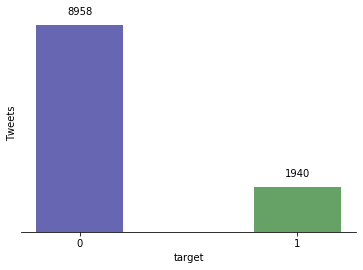

Non_Disaster tweets % :82.20


In [161]:
xs=df['target'].value_counts().index
ys=df['target'].value_counts().values
plt.figure()
plt.bar(xs,ys,
        color=['navy','darkgreen'],alpha=.6,width=.4)

plt.gca().axes.get_yaxis().set_ticks([])
plt.gca().axes.get_xaxis().set_ticks([0,1])
# plt.gca().axes.get_ticklabels(['non_disaster','disaster'])

plt.gca().set_facecolor('white')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)



for x,y in zip(xs,ys):

    label = "{}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or 
plt.grid(False)
plt.xlabel('target')
plt.ylabel('Tweets')

plt.show()
#print(len(df))
print('Non_Disaster tweets % :{:.2f}' .format((df['target'].value_counts()[0]/len(df))*100))

# Classification

In [162]:
# Splitting Data
from sklearn.model_selection import train_test_split
X=df_tfidf[0]
y=df['target']
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=0)

In [163]:
X.shape

(10898, 3879)

In [164]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
clf.fit(X_train,y_train)
print('Accuracy of train set: {:.2f}' .format(clf.score(X_train,y_train)))

Accuracy of train set: 0.90


In [165]:
print('Accuracy of test set: {:.2f}' .format(clf.score(X_test,y_test)))

Accuracy of test set: 0.88


In [166]:
from sklearn.metrics import classification_report
report= classification_report(y_test,clf.predict(X_test))
print('Classification Report:\n',report)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2251
           1       0.86      0.39      0.54       474

    accuracy                           0.88      2725
   macro avg       0.87      0.69      0.73      2725
weighted avg       0.88      0.88      0.86      2725



## Word Embedding

In [199]:
# 1.Word2Vec:
import gensim
# we are going to use pre_trained model from 'Google News dataset'

#import gensim_downloader as api
import gensim.downloader as api
wv=api.load('word2vec-google-news-300')
# to import smaller size of pre_trained model I will use the following code(only 200k most common words from Google News corpus loaded):
#word2vec_path= '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin' 
#word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=200000) 

KeyboardInterrupt: 

In [200]:
# obtain vectors for terms the model is familiar with:
vec_disaster=wv['disaster']

In [201]:
vec_disaster

array([ 0.23339844, -0.00067139, -0.05004883,  0.18945312,  0.18359375,
        0.21582031, -0.10400391, -0.33398438,  0.484375  , -0.12792969,
        0.00656128, -0.19726562,  0.02355957,  0.03515625,  0.02807617,
        0.39257812,  0.02526855,  0.08007812,  0.08056641, -0.375     ,
        0.12207031,  0.01928711,  0.02612305, -0.2109375 ,  0.26367188,
        0.13867188,  0.02368164, -0.36914062,  0.26953125, -0.12792969,
       -0.21875   ,  0.11230469, -0.06884766, -0.09375   , -0.18066406,
       -0.11914062, -0.11279297, -0.15429688, -0.01782227,  0.22070312,
        0.08984375, -0.07910156,  0.24511719,  0.03369141,  0.17871094,
       -0.27929688, -0.07177734,  0.30273438,  0.01495361,  0.37304688,
        0.03149414, -0.07910156,  0.0255127 ,  0.05737305, -0.21582031,
       -0.01672363, -0.2109375 , -0.06298828, -0.09960938,  0.012146  ,
       -0.18945312,  0.2109375 ,  0.03393555, -0.30273438, -0.01977539,
       -0.20898438,  0.05639648,  0.08740234,  0.11572266, -0.28

In [202]:
from gensim .models.keyedvectors import KeyedVectors
word_vectors=KeyedVectors.load_word2vec_format('C:/Users/Sepehr/Desktop/MachineLearning/Data Sets/GoogleNews-vectors-negative300.bin.gz',binary=True, limit=200000)

In [203]:
# Lets see the similiar words to disaster:
# To see which type of 
pairs = [
    ('disaster', 'thunderstorm'), 
    ('disaster', 'volcano'),   
    ('disaster', 'tornado'),  
    ('disaster', 'drought'),    
    ('disaster', 'fire'),
]
#for w1,w2 in pairs:
#    print('The similarity of {} and {} is {}' .format(w1,w2,wv.similarity(w1,w2)))
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, word_vectors.similarity(w1, w2)))

'disaster'	'thunderstorm'	0.21
'disaster'	'volcano'	0.25
'disaster'	'tornado'	0.42
'disaster'	'drought'	0.35
'disaster'	'fire'	0.23


In [204]:
# obtain vectors for terms the model is familiar with:
vec_disaster=word_vectors['disaster']

In [205]:
# Defining X,y
from sklearn.model_selection import train_test_split
text_train, text_test, y_train, y_test= train_test_split(df['text'],df['target'],random_state=42)

#### gensim.KeyedVectors.most_similar()
Method provides an efficient way to find the nearest neighbors for any given word vector.
Positive takes a list of the vectors to be added together, similar to your soccer team example.
Similarly, you can use the negative argument for subtraction and to exclude unrelated terms. 
The argument topn determines how many related terms should be provided as a return value.

In [206]:
word_vectors.most_similar(positive=['fire', 'forest', 'dry'],topn=5)

[('forest_fires', 0.6209976673126221),
 ('forests', 0.6181188225746155),
 ('fires', 0.6173016428947449),
 ('tinder_dry', 0.5834121108055115),
 ('wildland_fire', 0.5755112767219543)]

In [207]:
word_vectors.most_similar(positive=['tsunami','ground'],negative=['ocean'],topn=5)

[('Tsunami', 0.45853671431541443),
 ('tsunamis', 0.40876272320747375),
 ('earthquake', 0.38309282064437866),
 ('devastating_earthquake', 0.3745158314704895),
 ('quake', 0.3698951005935669)]

In [208]:
word_vectors.most_similar(positive=['Hurricane_Katrina','Louisiana' ],negative=['Alabama'],topn=5)

# Gustav, Rita are the hurricane happend in Alabama

[('Katrina', 0.7806007862091064),
 ('Hurricane_Gustav', 0.6598857641220093),
 ('Hurricane_Rita', 0.651625394821167),
 ('hurricanes_Katrina', 0.6423860788345337),
 ('Hurricane_Ike', 0.6333887577056885)]

In [209]:
# for fun, I compared Barcelona FC in Spain with what in England:
word_vectors.most_similar(positive=['Barcelona','England'],negative=['Spain'],topn=5)

[('Manchester', 0.5610477328300476),
 ('Arsenal', 0.5573516488075256),
 ('Leeds', 0.5344394445419312),
 ('Stamford_Bridge', 0.5229190587997437),
 ('Old_Trafford', 0.5213025808334351)]

#### gensim.KeyedVectors.doesnt_match()
To determine the most unrelated term of the list, the method returns the term with the highest distance to all other list terms.


In [210]:
word_vectors.doesnt_match('natural disaster sea'.split())

C:\Users\Sepehr\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'sea'

#### gensim.KeyedVectors.similarity()
The gensim library also allows you to calculate the similarity between two terms. If you want to compare two words and determine their cosine similarity.

In [240]:
word_vectors.similarity('disaster', 'earthquake')

0.5394472

In [212]:
word_vectors.similarity('Hurricane_Katrina', 'Hurricane_Ike')

0.73672867

In [213]:
word_vectors.similarity('Hurricane', 'Ike')

0.5555179

### Training a vector representation on disaster tweets:
The gensimword2vec model expects a list of sentences, where each sentence
is broken up into tokens.
To create vector repersentation of the words, word2vec needs a list of lists of tokens.

Detector Morse, by Kyle Gorman and OHSU on pypi and at https://github.com/cslu-nlp/DetectorMorse, is a sentence segmenter with state-of-the-art performance (98%) and has been pretrained on sentences from years of text in the Wall Street Journal. So if your corpus includes language similar to that in the WSJ, Detector Morse is likely to give you the highest accuracy currently possible. You can also retrain Detector Morse on your own dataset if you have a large set of sentences from your domain.

### Parameters to control word2vec model training:
num_features = 300
min_word_count = 3
num_workers = 2

or to have dynamic multiprocessing do the following:
import multiprocessing
num_workers=multiprocessing.cpu_count()

window_size = 6
subsampling = 1e-3 or between 1e-5 and 1e-6

In [216]:
# we are going to use 'lemmatized_word_with_pos'.

In [235]:
from gensim.models.word2vec import Word2Vec

# to have dynamic multiprocessing do the following:
num_features = 300
min_word_count = 3

import multiprocessing
num_workers=multiprocessing.cpu_count()

window_size = 6
subsampling = 1e-1
model=Word2Vec(df['lemmatized_word_with_pos'],
               workers=num_workers,
               size=num_features,
               min_count=min_word_count,
               window=window_size,
               sample=subsampling
              )

### Freezing the model:

The init_sims method will freeze the model, storing the weights of the hidden layer and discarding the output weights that predict word co-ocurrences. The output weights aren’t part of the vector used for most Word2vec applications. But the model cannot be trained further once the weights of the output layer have been discarded.


In [236]:
model.init_sims(replace=True)

### Saving and Loading a model:
You can save the trained model with the following command and preserve it for
later use.

In [237]:
model_name='my_domain_specific_word2vec_model'
model.save(model_name)

In [238]:
from gensim.models.word2vec import Word2Vec
model_name='my_domain_specific_word2vec_model'
model= Word2Vec.load(model_name)
model.most_similar('disaster', topn=5)

C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('near', 0.9977343082427979),
 ('earthquake', 0.9973839521408081),
 ('seismic', 0.9959284663200378),
 ('secretary', 0.9944243431091309),
 ('enormous', 0.9939168691635132)]

In [245]:
# the sample is very small and the result confirms the model is not good. Therefore, I will use google news model. 
from gensim.models.word2vec import Word2Vec
model_name='my_domain_specific_word2vec_model'
model= Word2Vec.load(model_name)

model.similarity('disaster', 'earthquake')
model.most_similar('disaster')

C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[('near', 0.9977343082427979),
 ('earthquake', 0.9973839521408081),
 ('seismic', 0.9959284663200378),
 ('secretary', 0.9944243431091309),
 ('enormous', 0.9939168691635132),
 ('explosion', 0.9939069747924805),
 ('temperature', 0.9937769770622253),
 ('powerful', 0.993468165397644),
 ('section', 0.9928772449493408),
 ('64', 0.9927276372909546)]

### fastText


In [242]:
from gensim.models.fasttext import FastText

fasttext_path = 'C:/Users/Sepehr/Desktop/MachineLearning/Data Sets/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec'
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=200000)

In [246]:
fasttext_model.similarity('disaster', 'earthquake')
fasttext_model.most_similar('disaster')

[('catastrophe', 0.8263336420059204),
 ('disasters', 0.8218443393707275),
 ('calamity', 0.7924492955207825),
 ('Disaster', 0.7637386918067932),
 ('tragedy', 0.7395144104957581),
 ('catastrophes', 0.6992127299308777),
 ('calamities', 0.6484513282775879),
 ('devastation', 0.6451743841171265),
 ('crisis', 0.6386182308197021),
 ('accident', 0.6301858425140381)]

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train)
X_train_vect = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train_vect)))

X_train:
<8200x18286 sparse matrix of type '<class 'numpy.int64'>'
	with 121848 stored elements in Compressed Sparse Row format>


In [34]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

# As can be seen in below, 18268 features are a lot. we should find a way to decrease the number of features. 
# But before let see how is the performance of our model.  

Number of features: 18286
Every 2000th feature:
['00', 'becaus', 'cosmopolitan', 'extinct', 'hurst', 'make', 'pauli', 'runners', 'tamara', 'write']


In [25]:
# Lets check LogisticRegression on this data set
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

scores = cross_val_score(LogisticRegression(), X_train_vect, y_train, cv=5,scoring='roc_auc')

print("Mean cross-validation AUC: {:.2f}".format(np.mean(scores)))



Mean cross-validation AUC: 0.88


In [141]:
# Lets decrese the number of features with lemmatization:
#      Do not run this code
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['text_lemmatized'] = df['text'].apply(lemmatize_text)
#vect = CountVectorizer().fit(text_train)
#X_train = vect.transform(text_train)
df['text_lemmatized'].iloc[:20]

#print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word, pos="v")))



In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.linear_model import LogisticRegression

vect = CountVectorizer(min_df=5).fit(text_train)
print('The number iof features in countVectorizor: ',len(vect.get_feature_names()))

X_train_vectorized = vect.transform(text_train)
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(text_test))

print('CountVectorizer AUC: ', roc_auc_score(y_test, predictions))
print('CountVectorizer f1: ', f1_score(y_test, predictions))

The number iof features in countVectorizor:  3171
CountVectorizer AUC:  0.767954623352087
CountVectorizer f1:  0.6625766871165644


C:\Users\Sepehr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
# Lets use tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score 

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
# X_train=df['text_lemmatized']
vect = TfidfVectorizer(min_df=5).fit(text_train)
print('The number of features in tf-idf: ',len(vect.get_feature_names()))

X_train_vectorized = vect.transform(text_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(text_test))

print('tf-idf AUC: ', roc_auc_score(y_test, predictions))
print('tf-idf f1: ', f1_score(y_test, predictions))

The number of features in tf-idf:  3171
tf-idf AUC:  0.6839081580807531
tf-idf f1:  0.527536231884058


In [48]:
# n-gram- count
# lets try to see if the combination of words can improve the performance of the model
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(text_train)

X_train_vectorized = vect.transform(text_train)
print('The number iof features in countVectorizor: ',len(vect.get_feature_names()))
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(text_test))
print('CountVectorizer AUC: ', roc_auc_score(y_test, predictions))
print('tf-idf f1: ', f1_score(y_test, predictions))


The number iof features in countVectorizor:  5470
CountVectorizer AUC:  0.7565863110249129
tf-idf f1:  0.6427688504326329


In [50]:
# n-gram- tf-idf
# lets try to see if the combination of words can improve the performance of the model
# Fit the TfidfVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = TfidfVectorizer(min_df=5, ngram_range=(1,2)).fit(text_train)

X_train_vectorized = vect.transform(text_train)
print('The number iof features in TfidfVectorizor: ',len(vect.get_feature_names()))
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

predictions = model.predict(vect.transform(text_test))
print('tf-idf AUC: ', roc_auc_score(y_test, predictions))
print('tf-idf f1: ', f1_score(y_test, predictions))


The number iof features in TfidfVectorizor:  5470
tf-idf AUC:  0.6813254640350217
tf-idf f1:  0.526002971768202


In [140]:
# lets try to improve the performance by tunning hyperparameters
from sklearn.model_selection import GridSearchCV
pipe=Pipeline([('clf',LogisticRegression())])
param_grid = {'clf__C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

C:\Users\Sepehr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Sepehr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                                 